In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self,xmin,xmax,num_points):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmax,xmin,num_points)
        self.y_true = np.sin(self.x_data)
        
    
    def ret_true(self,x_series):#useful for comparing the data we dont have
        return np.sin(x_series)# for any x series it returns the sin of it.
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        #Grab a rndom starting point for each point
        rand_start = np.random.rand(batch_size,1)
        
        #Convert to be on time series
        #ts_start starting point of the time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        #create batch time series on x axis
        batch_ts = ts_start +np.arange(0.0,steps+1) * self.resolution
        
        #create the y datafor the time series x axis from the previous step
        y_batch = np.sin(batch_ts)
        
        #formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1) , batch_ts#it returns y_batch along with the batch_ts
        else:#it returns only y_batch
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1)#[:,:]: the first is for rows and : second is for columns
        # y_batch[:,:-1].reshape(-1,steps,1) this represents the time series and
        # y_batch[:,1:].reshape(-1,steps,1) time series shifted over by one time step

# create time series data

In [3]:
ts_data = TimeSeriesData(0,10,250)#250 points between 0 to 10 

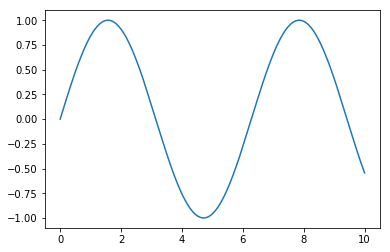

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
num_time_steps = 30 #number of steps in batch

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)#true means i want the time series data

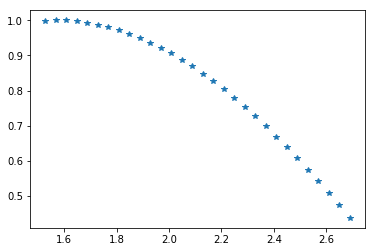

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')#[1:] because they both have diffrent dimension first have 30 and other have 31 so balance it we write [1:]

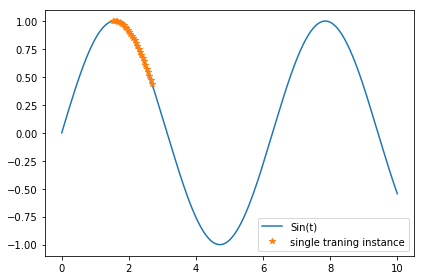

In [8]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='single traning instance')
plt.legend()
plt.tight_layout()#not blocking the image

# TRAINING DATA

In [9]:
train_inst = np.linspace(5 , 5 + ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [10]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

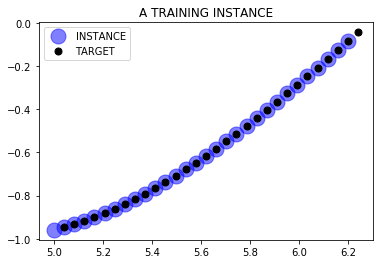

In [11]:
# this is the actual data we are going to feed in our model and training it
#training instance is for prediction is not the actual data
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='INSTANCE')#bo is blue circle marker
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize=7,label='TARGET')#ko is black circle marker
plt.legend()
#blue is the training and black is the target
#given this blue points can you generate black points

# creating the model

# constants

In [12]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 5000
# Size of the batch of data
batch_size = 1

# placeholders

In [13]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

# RNN cell layer

In [14]:
#cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu)
# we have to wrap because no of nreurons is 100 and we want the output 1 so we have to wrap up this
#cell = tf.contrib.rnn.OutputProjectionWrapper(cell,output_size=num_outputs)

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

In [15]:
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs)

In [16]:
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs)

In [17]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# loss function

In [18]:
# MEAN SQUARED ERROR
loss = tf.reduce_mean(tf.square(outputs - y))

# optimizer

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [20]:
train = optimizer.minimize(loss)

In [21]:
init = tf.global_variables_initializer()

# session

In [22]:
gpu_option= tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [23]:
saver = tf.train.Saver()

In [24]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    

            
    saver.save(sess,"./row_data_rnn_time_series_model")    

0 	MSE: 0.615717
100 	MSE: 0.113127
200 	MSE: 0.00691547
300 	MSE: 0.0218757
400 	MSE: 0.010135
500 	MSE: 0.0139105
600 	MSE: 0.00337382
700 	MSE: 0.0253056
800 	MSE: 0.00855466
900 	MSE: 0.000127854
1000 	MSE: 0.0098484
1100 	MSE: 0.0203397
1200 	MSE: 0.00702177
1300 	MSE: 0.000758899
1400 	MSE: 0.00592264
1500 	MSE: 0.0144922
1600 	MSE: 0.00198
1700 	MSE: 0.0148602
1800 	MSE: 0.00110266
1900 	MSE: 0.000268093
2000 	MSE: 0.00136357
2100 	MSE: 0.00115462
2200 	MSE: 0.00700094
2300 	MSE: 0.00181109
2400 	MSE: 0.00577365
2500 	MSE: 0.000247291
2600 	MSE: 6.56001e-05
2700 	MSE: 0.000971272
2800 	MSE: 0.000247878
2900 	MSE: 3.65512e-05
3000 	MSE: 0.00368595
3100 	MSE: 0.000109766
3200 	MSE: 0.000447323
3300 	MSE: 0.000139813
3400 	MSE: 0.000533113
3500 	MSE: 0.000133762
3600 	MSE: 0.000162472
3700 	MSE: 0.00357199
3800 	MSE: 0.000171966
3900 	MSE: 0.00174756
4000 	MSE: 5.59898e-05
4100 	MSE: 0.00217949
4200 	MSE: 0.000460859
4300 	MSE: 0.000238434
4400 	MSE: 5.73765e-05
4500 	MSE: 0.000419

In [25]:
with tf.Session() as sess:
    saver.restore(sess,"./row_data_rnn_time_series_model")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./row_data_rnn_time_series_model


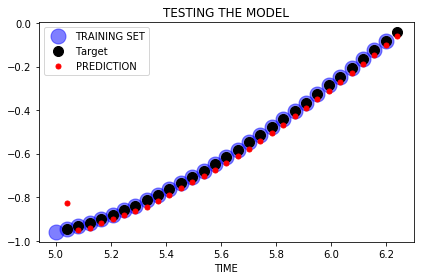

In [26]:
plt.title("TESTING THE MODEL")

#TRANING THE INSTANCE
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label="TRAINING SET")

#TARGET TO PREDICT(CORRCT TEST VALUES np.sin(train))
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=10,label="Target")#[1:] 1 step future

#MODEL PREDICTION
plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize=10,label="PREDICTION")

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()

# Generating new sequence

In [27]:
with tf.Session() as sess:
    saver.restore(sess, "./row_data_rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./row_data_rnn_time_series_model


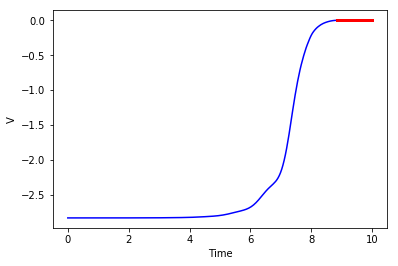

In [28]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("V")



In [31]:
with tf.Session() as sess:
    saver.restore(sess, "./row_data_rnn_time_series_model")
    
    writer = tf.summary.FileWriter("/output/RNN",sess.graph)
    
    # SEED WITH ZEROS
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(training_instance) - num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])
        writer.close()

INFO:tensorflow:Restoring parameters from ./row_data_rnn_time_series_model


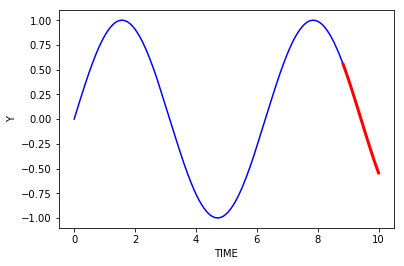

In [32]:
plt.plot(ts_data.x_data,ts_data.y_true,'b-')#plot entire time series
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps],'r',linewidth=3)#first seed value
plt.xlabel('TIME')
plt.ylabel('Y')